# Network analysis - Dsitributional anlysis and GSEA

**Context**

This notebook loads in cell-type specifc Gene Regulatory Networks (GRNs) with the format: 'source' - 'target'. Where source refers to a Transcription Factor (TF) and target refers to a gene. The relationship i.e. row indicates that the TF under 'source' is targeting the gene under 'target' for activation of transcription. These celltype-specifc GRNs were created using the pipeline 'GRN_reconstruction_whole_data' by Abdool Al-Khaledi (a.g.al-khaledi@students.uu.nl). The pipeline takes as input a CellxGene Matrix and exports a file for each celltype containing the GRN in a 'source' - 'target' table format. This notebook carries out the second part of the analysis: Idenitfying cell-types enriched in ASD regulon activity.

**Objective**

The purpose of this notebook is to quantify the involvement of Autism Spectrum Disorder (ASD) genes/TFs in each celltype to determine which celltypes are enriched in ASD - TFs/genes at the level of the GRN. We then subset these interactions and run pathway enrichment analysis to identify the biochemical pathways which are most compromised when an ASD-TF is mutated.

**Summary**

The notebook begins by loading and inpecting the complete GRN for each celltype, to produce a summary table called GRN_df. We then define some metrics to quantify the embedding of ASD genes/TFs in each network. We then define a new subset of networks with a summary table called ASD_GRN_df. These networks contain ASD TFs and their corresponding target genes- **only if the target is exclusively targeted by an Autism-related-TF.** This to account for the fact that even if an ASD TF is mutated, we cannot infer a significant effect on the target gene if the target gene will also be activated by a non-ASD TF.   

Lastly, we run pathway enrichment analysis on the ASD subsets, the purpose of which is two-fold. Firstly, this helps us identify the protein pathways most at-risk in the case of a mutated ASD TF in a celltype specifc way. Secondly, it can help us validate the analysis if we identify patyhways we expect.


In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import shapiro #test for normality
from scipy.stats import mannwhitneyu #test significance between groups
import gseapy as gp # GSEA analysis

The 'Autism-related' genes/TFs are identified through the SFARI gene database https://gene.sfari.org/, which is a curated database of ASD genes with an associated confidence score: 1,2,3.

In [2]:
# Loading ASD genes 
os.chdir("/GRN_reconstruction/Mouse orthologues of SFARI genes/")

# Read csv containing gene names        
autism_genes = pd.read_csv("autism_genes.csv")

# Locate genes with SFARI gene score of 1,2 or 3        
autism_genes_1_2_3_df = pd.concat([autism_genes.loc[autism_genes['gene-score']==1], autism_genes.loc[autism_genes['gene-score']==2], autism_genes.loc[autism_genes['gene-score']==3]])

# Create gene list
autism_genes_1_2_3 = np.unique(np.unique(autism_genes_1_2_3_df['Mouse gene name']).tolist())

## Part 1 - Total GRN information ##

Here we define some metrics in order to capture relevant information about the ASD genes in our networks. 

In [3]:
# Set path to directory containing network tables
network_dir = "" # Path to directory containing network files


# Create empty lists to store results
filenames = []
GRN_activity_list = []
unique_ASD_TFs_list = []
free_floating_ASD_targets_list = []
ASD_Activity_list = []
ASD_genes_list = []
ASD_sources_list = []


# Iterate over files in directory
for filename in os.listdir(network_dir):
    if filename.endswith('.csv'):
        # Read network table
        network_path = os.path.join(network_dir, filename)
        network = pd.read_csv(network_path)
        
        # Calculate GRN activity. i.e: Total number of interactions in network, including everything.
        GRN_activity = network.shape[0]
        
        # Define set of ASD genes
        ASD_genes = set(autism_genes_1_2_3)

        # Calculate number of unique ASD TFs in network
        unique_ASD_TFs = len(set(network['source']).intersection(ASD_genes))

        # Calculate free-floating ASD targets. i.e: count rows where target is ASD gene and corresponing source is non ASD-TF.
        targets = set(network['target'])
        free_floating_ASD_targets = sum(network['target'].isin(ASD_genes) & ~network['source'].isin(ASD_genes))
        
        # Calculate ASD genes. i.e: count rows where target is an ASD gene.
        ASD_genes_count = network['target'].isin(ASD_genes).sum()
        ASD_genes_list.append(ASD_genes_count)
        
        # Calculate ASD sources. i.e: count rows where source is an ASD gene.
        ASD_sources_count = network['source'].isin(ASD_genes).sum()
        ASD_sources_list.append(ASD_sources_count)
        
        # Count rows where either source or target is an ASD gene "ASD edges"
        ASD_Activity = network[network['source'].isin(ASD_genes) | network['target'].isin(ASD_genes)].shape[0]

        # Store results in lists
        filenames.append(filename)
        GRN_activity_list.append(GRN_activity)
        unique_ASD_TFs_list.append(unique_ASD_TFs)
        free_floating_ASD_targets_list.append(free_floating_ASD_targets)
        ASD_Activity_list.append(ASD_Activity)

# Create a single dataframe with results
GRN_df = pd.DataFrame({
    'Cell-type': filenames,
    'GRN_Activity': GRN_activity_list,
    'unique_ASD_TFs':unique_ASD_TFs_list,
    'free_floating_ASD_targets':free_floating_ASD_targets_list,
    'ASD_Activity':ASD_Activity_list,
    'ASD_genes': ASD_genes_list,
    'ASD_sources': ASD_sources_list
})

#Set index as celltype
GRN_df.set_index('Cell-type', inplace=True)


## Part 2 - ASD Regulon  information ##

**This part of the Notebook Subsets the celltype specifc GRNs, including interactions which satisfy:** 

**1-The source is an ASD TF.**

**2-The target is not targeted by a non-ASD TF.**

In [4]:
# Create ASD & non_ASD subfolders, if they do not exist. We will populate these folders in the next step. import os

def create_directories(base_dir, *dirs):
    [os.makedirs(os.path.join(base_dir, d), exist_ok=True) for d in dirs]

base_dir = ".../networks/" # Path to directory containing network files
create_directories(base_dir, 'ASD', 'non_ASD')


In [4]:
#Subset ASD TFs and targets only targeted by ASD TFs
#Define the input and output directories
input_dir = '.../networks/' # Path to directory containing network files
output_dir = '.../networks/ASD'

# Loop over each CSV file (celltype-specifc network) in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):
        # Read in the network
        df = pd.read_csv(os.path.join(input_dir, filename))
        
        # Identify the subset of targets connected to ASD sources
        asd_nodes = set(df[df['source'].isin(autism_genes_1_2_3)]['target'])
        
        # Identify the subset of targets connected to non-ASD sources
        non_asd_nodes = set(df[~df['source'].isin(autism_genes_1_2_3)]['target'])
        
        # Identify the intersection of these target sets
        overlapping_nodes = asd_nodes.intersection(non_asd_nodes)
        
        # If an ASD source is connected to a taget in overlapping_nodes, remove that interaction
        df = df[~((df['source'].isin(autism_genes_1_2_3)) & (df['target'].isin(overlapping_nodes)))]
        
        # Identify the targets unique to ASD TF sources
        target_genes = set(df[df['source'].isin(autism_genes_1_2_3)]['target'])
        
        # Identify rows where source is ASD TF and target is unique to ASD TF(s)
        df = df[(df['source'].isin(autism_genes_1_2_3)) &  (df['target'].isin(target_genes))]

        # Export the subsetted networks to output_dire
        output_filename = os.path.join(output_dir, filename)
        df.to_csv(output_filename, index=False)

In [4]:
# Calculate ASD regulon metric. By counting the rows of the subsetted networks(s)
# Set path to directory containing network tables
network_dir = os.path.join( '...networks/ASD')

# Create empty lists to store results
filenames = []
ASD_GRN_activity_list = []

# Iterate over files in directory
for filename in os.listdir(network_dir):
    if filename.endswith('.csv'):
        # Read network table
        network_path = os.path.join(network_dir, filename)
        network = pd.read_csv(network_path)
        
        # Define set of ASD genes
        ASD_genes = set(autism_genes_1_2_3)

        # Calculate ASD-GRN activity
        ASD_GRN_activity = network.shape[0]
        
        # Store results in lists
        filenames.append(filename)
        ASD_GRN_activity_list.append(ASD_GRN_activity)

# Create a single dataframe 
ASD_GRN_df = pd.DataFrame({
    'name': filenames,
    'ASD_GRN_activity': ASD_GRN_activity_list,
})

#Set index as celltype
ASD_GRN_df.set_index('name', inplace=True)

# Sort the values based on ASD_GRN_activity column
ASD_GRN_df = ASD_GRN_df.sort_values('ASD_GRN_activity', ascending=False)

## Part 3 - Control Regulon  information ##

In [6]:
# Subset non-ASD TFs and targets only targeted by non-ASD TFs
# Define the input and output directories
input_dir = '...networks/'
output_dir = '.../networks/non_ASD'

# Loop over each CSV file (celltype-specifc network) in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):
        # Read in the network
        df = pd.read_csv(os.path.join(input_dir, filename))
        
        # Identify the subset of targets connected to non-ASD sources
        non_asd_nodes = set(df[~df['source'].isin(autism_genes_1_2_3)]['target'])
        
        # Identify the subset of targets connected to ASD sources
        asd_nodes = set(df[df['source'].isin(autism_genes_1_2_3)]['target'])
        
        # Identify the intersection of these target sets
        overlapping_nodes = non_asd_nodes.intersection(asd_nodes)
        
        # If a non-ASD source is connected to a target in overlapping_nodes, remove that interaction
        df = df[~((~df['source'].isin(autism_genes_1_2_3)) & (df['target'].isin(overlapping_nodes)))]
        
        # Identify the targets unique to non-ASD TF sources
        target_genes = set(df[~df['source'].isin(autism_genes_1_2_3)]['target'])
        
        # Identify rows where source is non-ASD TF and target is unique to non-ASD TF(s)
        df = df[(~df['source'].isin(autism_genes_1_2_3)) &  (df['target'].isin(target_genes))]

        # Export the subsetted networks to output_dir
        output_filename = os.path.join(output_dir, filename)
        df.to_csv(output_filename, index=False)

In [6]:
# Create control TF GRN. i.e. Non ASD TFs and their exclusive targets
# Set path to directory containing network tables
network_dir = os.path.join( '../networks/non_ASD')

# Create empty lists to store results
filenames = []
CT_TF_activity_list = []


# Iterate over files in directory
for filename in os.listdir(network_dir):
    if filename.endswith('.csv'):
        # Read network table
        network_path = os.path.join(network_dir, filename)
        network = pd.read_csv(network_path)

        # Calculate ASD-GRN activity
        CT_TF_activity = network.shape[0]

        # Store results in lists
        filenames.append(filename)
        CT_TF_activity_list.append(CT_TF_activity)

# Create a single dataframe 
CT_GRN_df = pd.DataFrame({
    'name': filenames,
    'CT_TF_activity': CT_TF_activity_list,
})

#Set index as celltype
CT_GRN_df.set_index('name', inplace=True)

# Sort the values based on ASD_GRN_activity column
CT_GRN_df = CT_GRN_df.sort_values('CT_TF_activity', ascending=False)

## Part 4 - Combine into 1 Dataframe and inspect ##

In [7]:
# Add columns from GRN_df to ASD_GRN_df

# Extract the indices of the rows that are present in both dataframes
common_rows = list(set(GRN_df.index).intersection(set(ASD_GRN_df.index)))

# Create a new dataframe by merging the common rows and selected columns from both dataframes
ASD_GRN_df = pd.merge(ASD_GRN_df.loc[common_rows], 
                     GRN_df[['GRN_Activity', 'unique_ASD_TFs', 'free_floating_ASD_targets','ASD_Activity','ASD_sources','ASD_genes']], 
                     left_index=True, right_index=True)


In [8]:
# Add columns from CT_GRN_df to ASD_GRN_df

# Extract the indices of the rows that are present in both dataframes
common_rows = list(set(CT_GRN_df.index).intersection(set(ASD_GRN_df.index)))

# Create a new dataframe by merging the common rows and selected columns from both dataframes
ASD_GRN_df = pd.merge(ASD_GRN_df.loc[common_rows], 
                     CT_GRN_df['CT_TF_activity'], 
                     left_index=True, right_index=True)


In [9]:
ASD_GRN_df

,ASD_GRN_activity,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_sources,ASD_genes,CT_TF_activity
Microglia.csv,25,7072,4,747,885,138,764,6473
Interneurons.csv,395,7318,6,750,1726,976,888,4885
Cycling glial cells.csv,44,6334,5,730,946,216,764,5578
Pericytes.csv,70,5460,7,571,833,262,613,4644
VLMC.csv,57,5878,7,616,866,250,651,5062
Astrocytes.csv,79,6741,7,738,1048,310,781,5732
Red blood cells.csv,13,3497,2,356,397,41,361,3369
Immature neurons.csv,48,6450,6,748,987,239,777,5643
DL_CPN_2.csv,383,4857,8,457,1310,853,598,3119
CThPN.csv,354,7580,7,781,1730,949,918,5068


In [10]:
# Outlier detection using MAD
# Function to calculate the MAD
def median_absolute_deviation(data, threshold=3):
    median = data.median()
    mad = (data - median).abs().median()
    scaled_deviation = ((data - median) / mad).abs()
    return scaled_deviation > threshold

# Calculate the MAD for the 'GRN_Activity' column and get the outlier mask
outlier_mask = median_absolute_deviation(ASD_GRN_df['GRN_Activity'])

# Identify the outlier cell types
outliers = ASD_GRN_df[outlier_mask]

# Print the outliers
print(outliers)
ASD_GRN_df = ASD_GRN_df.drop(outliers.index)

                     ASD_GRN_activity  GRN_Activity  unique_ASD_TFs  \
Red blood cells.csv                13          3497               2   
Ependymocytes.csv                  69          4054               7   

                     free_floating_ASD_targets  ASD_Activity  ASD_sources  \
Red blood cells.csv                        356           397           41   
Ependymocytes.csv                          481           736          255   

                     ASD_genes  CT_TF_activity  
Red blood cells.csv        361            3369  
Ependymocytes.csv          520            3329  


In [11]:
pd.options.display.max_rows = len(ASD_GRN_df)

# Display the dataframe
display(ASD_GRN_df)

,ASD_GRN_activity,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_sources,ASD_genes,CT_TF_activity
Microglia.csv,25,7072,4,747,885,138,764,6473
Interneurons.csv,395,7318,6,750,1726,976,888,4885
Cycling glial cells.csv,44,6334,5,730,946,216,764,5578
Pericytes.csv,70,5460,7,571,833,262,613,4644
VLMC.csv,57,5878,7,616,866,250,651,5062
Astrocytes.csv,79,6741,7,738,1048,310,781,5732
Immature neurons.csv,48,6450,6,748,987,239,777,5643
DL_CPN_2.csv,383,4857,8,457,1310,853,598,3119
CThPN.csv,354,7580,7,781,1730,949,918,5068
Endothelial cells.csv,49,7216,7,826,1126,300,868,6021


Shapiro-Wilk test: stat=0.9645, p-value=0.5853


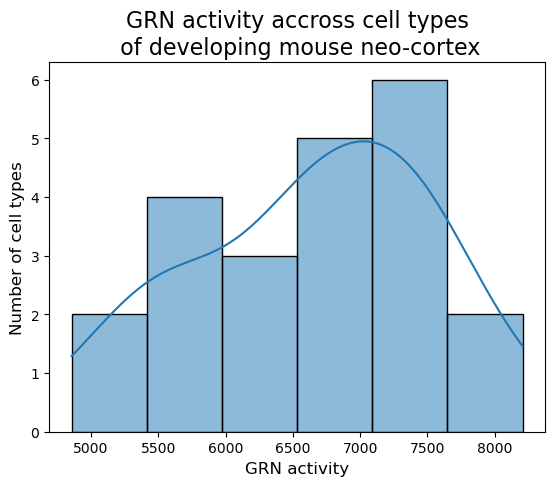

In [37]:
# Plot distribution of GRN activity accross celltypes
sns.histplot(ASD_GRN_df['GRN_Activity'], kde=True)
plt.title("GRN activity accross cell types\n of developing mouse neo-cortex",size=16)
plt.xlabel('GRN activity',size=12)
plt.ylabel('Number of cell types',size=12)
# Test for normality using shapiro test. p > 0.05 means normal ditribution.
stat, p = shapiro(ASD_GRN_df['GRN_Activity'])
print(f"Shapiro-Wilk test: stat={stat:.4f}, p-value={p:.4f}")

# Save the plot with the specified DPI
#output_path = r"/GRN distribution whole data.jpeg"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

Shapiro-Wilk test: stat=0.9543, p-value=0.3836


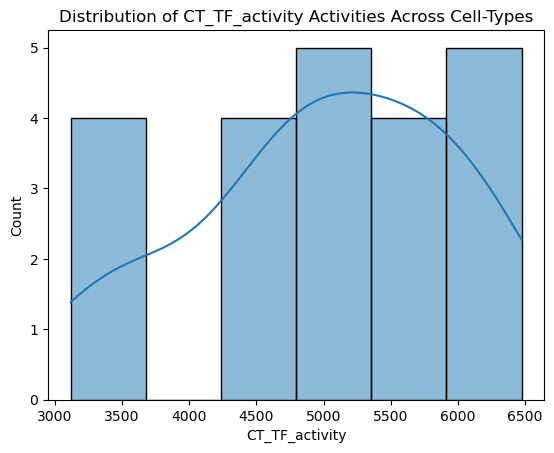

In [17]:
# Plot distribution of CT_TF activity accross celltypes
sns.histplot(ASD_GRN_df['CT_TF_activity'], kde=True)
plt.title("Distribution of CT_TF_activity Activities Across Cell-Types")

# Test for normality using shapiro test. p > 0.05 means normal ditribution.
stat, p = shapiro(ASD_GRN_df['CT_TF_activity'])
print(f"Shapiro-Wilk test: stat={stat:.4f}, p-value={p:.4f}")


Shapiro-Wilk test: stat=0.9126, p-value=0.0536


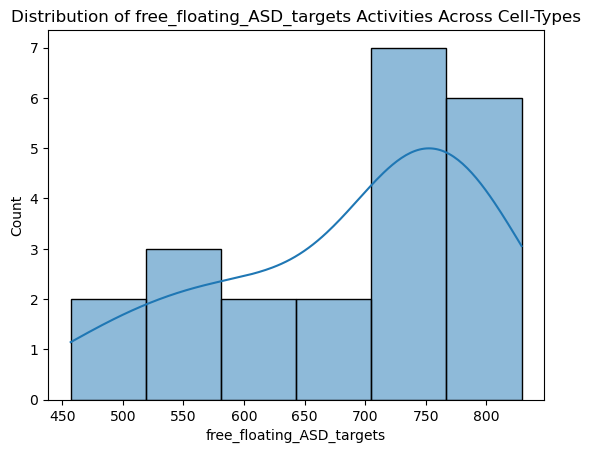

In [18]:
# Plot distribution of free_floating_ASD_targets activity accross celltypes
sns.histplot(ASD_GRN_df['free_floating_ASD_targets'], kde=True)
plt.title("Distribution of free_floating_ASD_targets Activities Across Cell-Types")

# Test for normality using shapiro test. p > 0.05 means normal ditribution.
stat, p = shapiro(ASD_GRN_df['free_floating_ASD_targets'])
print(f"Shapiro-Wilk test: stat={stat:.4f}, p-value={p:.4f}")


Shapiro-Wilk test: stat=0.8828, p-value=0.0137


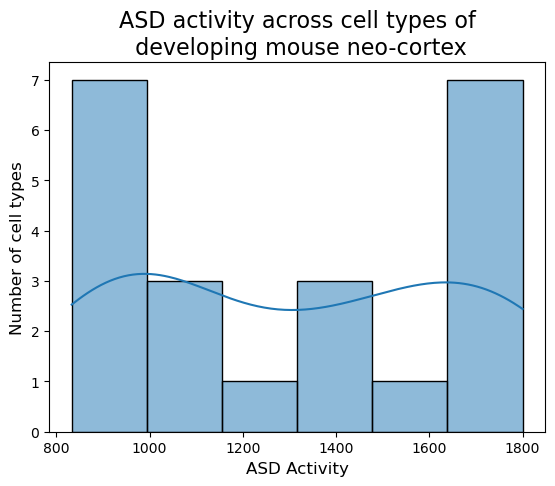

In [28]:
# Plot distribution of ASD activity accross celltypes
sns.histplot(ASD_GRN_df['ASD_Activity'], kde=True)
plt.title("ASD activity across cell types of\n developing mouse neo-cortex", size =16)
plt.xlabel('ASD Activity',size=12)
plt.ylabel('Number of cell types',size=12)
# Test for normality using shapiro test. p > 0.05 means normal ditribution.
stat, p = shapiro(ASD_GRN_df['ASD_Activity'])
print(f"Shapiro-Wilk test: stat={stat:.4f}, p-value={p:.4f}")

# Save the plot with the specified DPI
#output_path = r"/ASD activity distribution whole data.jpeg"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

Shapiro-Wilk test: stat=0.7689, p-value=0.0002


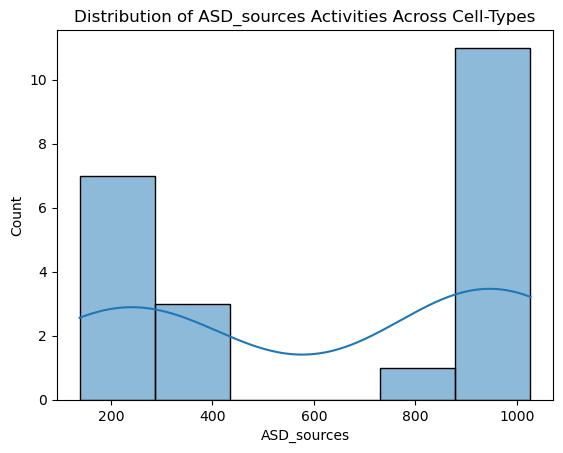

In [20]:
# Plot distribution of ASD TFs accross celltypes
sns.histplot(ASD_GRN_df['ASD_sources'], kde=True)
plt.title("Distribution of ASD_sources Activities Across Cell-Types")

# Test for normality using shapiro test. p > 0.05 means normal ditribution.
stat, p = shapiro(ASD_GRN_df['ASD_sources'])
print(f"Shapiro-Wilk test: stat={stat:.4f}, p-value={p:.4f}")


Shapiro-Wilk test: stat=0.9686, p-value=0.6784


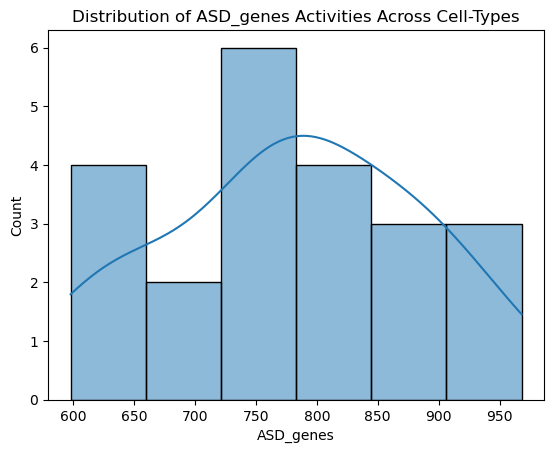

In [21]:
# Plot distribution of ASD genes accross celltypes
sns.histplot(ASD_GRN_df['ASD_genes'], kde=True)
plt.title("Distribution of ASD_genes Activities Across Cell-Types")

# Test for normality using shapiro test. p > 0.05 means normal ditribution.
stat, p = shapiro(ASD_GRN_df['ASD_genes'])
print(f"Shapiro-Wilk test: stat={stat:.4f}, p-value={p:.4f}")


In [16]:
ASD_GRN_df

,ASD_GRN_activity,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_sources,ASD_genes,CT_TF_activity
Neur684.csv,72,3057,8,338,560,222,371,2533
Neur546.csv,60,2769,7,321,487,166,341,2363
GblF1.csv,28,4116,4,399,527,128,411,3708
Immune1.csv,24,3855,5,358,496,138,375,3395
Chpl3.csv,20,4138,4,455,574,119,472,3739
...,...,...,...,...,...,...,...,...
Neur742.csv,256,4511,9,519,1213,694,635,2918
Neur753.csv,299,3749,7,434,1109,675,543,2334
RglF12.csv,47,4955,5,505,682,177,524,4419
PvmCyc.csv,12,5722,3,514,607,93,524,5288


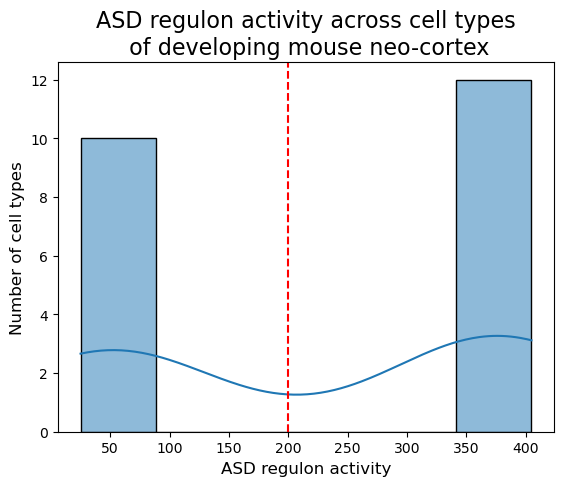

In [29]:
sns.histplot(ASD_GRN_df['ASD_GRN_activity'], kde=True)
plt.title("ASD regulon activity across cell types\n of developing mouse neo-cortex", size=16)
plt.xlabel("ASD regulon activity",size =12)  # Set x-axis label
plt.ylabel("Number of cell types", size =12)  # Set x-axis label


# Add a vertical line at x=200
plt.axvline(x=200, color='r', linestyle='--')

# Select celltypes above cutoff
subsetted_rows = ASD_GRN_df.loc[ASD_GRN_df['ASD_GRN_activity'] > 200]

# Save the plot with the specified DPI
#output_path = r"/ASD Regulon distribution whole data.jpeg"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [51]:
len(ASD_GRN_df)

22

In [22]:
subsetted_rows

,ASD_GRN_activity,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_sources,ASD_genes,CT_TF_activity
Interneurons.csv,395,7318,6,750,1726,976,888,4885
SCPN.csv,354,8207,7,829,1800,971,968,5545
DL_CPN_2.csv,383,4857,8,457,1310,853,598,3119
Oligodendrocytes.csv,352,7304,8,727,1754,1027,875,4627
DL CPN.csv,405,6731,7,650,1640,990,792,4458
Layer 4.csv,401,7422,8,690,1712,1022,838,4870
DL_CPN_1.csv,405,5562,8,493,1428,935,636,3582
NP.csv,404,5376,8,528,1411,883,666,3483
CThPN.csv,354,7580,7,781,1730,949,918,5068
Cajal Retzius cells.csv,352,6519,7,619,1508,889,751,4382


In [26]:
# Extract the values of the column for the selected rows
values = subsetted_rows['ASD_GRN_activity'].tolist()

# Return a list of tuples with the rows and their ASD_TF_activity
rows_and_values = list(zip(subsetted_rows.index.tolist(), values))

# Print the list of celltypes and their corresponding ASD_TF_activity
print(rows_and_values)

[('Interneurons.csv', 395), ('SCPN.csv', 354), ('DL_CPN_2.csv', 383), ('Oligodendrocytes.csv', 352), ('DL CPN.csv', 405), ('Layer 4.csv', 401), ('DL_CPN_1.csv', 405), ('NP.csv', 404), ('CThPN.csv', 354), ('Cajal Retzius cells.csv', 352), ('UL CPN.csv', 365), ('Layer 6b.csv', 350)]


*Significance testing*

In [42]:
# Perform Mann-Whitney test for differences between celltypes with ASD_GRN_activity >200 vs. all other celltypes.

#Group 1 contains celltypes which passed cutoff
group_1 = ASD_GRN_df.loc[subsetted_rows.index] 
#Group 2 contains all other celltypes
group_2 = ASD_GRN_df.loc[~ASD_GRN_df.index.isin(group_1.index)]

#Cclaculate test result and perform post-hoc test if necessary.
for column in ASD_GRN_df.columns:
    # check if column exists in both group_1 and group_2
    if column in group_1.columns and column in group_2.columns:
        # check if column values are the same in group_1 and group_2
        if group_1[column].equals(group_2[column]):
            print(f"Mann-Whitney test for {column}: p-value = NaN (group_1 and group_2 have the same values)")
        else:
            test_result = mannwhitneyu(group_1[column], group_2[column])
            print(f"Mann-Whitney U test for {column}: p-value = {test_result.pvalue}")
            
            # perform posthoc test
            if test_result.pvalue < 0.05:
                if group_1[column].mean() > group_2[column].mean():
                    print(f"Group 1 is larger than Group 2 for {column}")
                else:
                    print(f"Group 2 is larger than Group 1 for {column}")
            else:
                print(f"No significant difference found between Group 1 and Group 2 for {column}")
    else:
        print(f" {column} does not exist in both group_1 and group_2")


Mann-Whitney U test for ASD_GRN_activity: p-value = 8.574357511537998e-05
Group 1 is larger than Group 2 for ASD_GRN_activity
Mann-Whitney U test for GRN_Activity: p-value = 0.5751565767276567
No significant difference found between Group 1 and Group 2 for GRN_Activity
Mann-Whitney U test for unique_ASD_TFs: p-value = 0.0036139318016745617
Group 1 is larger than Group 2 for unique_ASD_TFs
Mann-Whitney U test for free_floating_ASD_targets: p-value = 0.19851568979039613
No significant difference found between Group 1 and Group 2 for free_floating_ASD_targets
Mann-Whitney U test for ASD_Activity: p-value = 8.733926588357827e-05
Group 1 is larger than Group 2 for ASD_Activity
Mann-Whitney U test for ASD_sources: p-value = 8.693824275833165e-05
Group 1 is larger than Group 2 for ASD_sources
Mann-Whitney U test for ASD_genes: p-value = 0.4285334457236526
No significant difference found between Group 1 and Group 2 for ASD_genes
Mann-Whitney U test for CT_TF_activity: p-value = 0.0006842598049

In [35]:
len(subsetted_rows)

98

## Part 3 - Subset ASD regulons for EnrichR and perform GSEA

In [6]:
# Create folder to store enrichr results 
base_dir = '.../networks/ASD'
create_directories(base_dir, 'celltypeTFs')

In [29]:
# Input directory containing CSV files
input_dir = '.../networks/ASD'

# Output directory for gene list text files
output_dir = '.../networks/ASD/celltypeTFs/'



# Iterate over all the CSV files in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        # Load the CSV file into a pandas DataFrame
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)

        # Create a subdirectory for each CSV file
        csv_output_dir = os.path.join(output_dir, os.path.splitext(file_name)[0])
        os.makedirs(csv_output_dir, exist_ok=True)

        # Iterate over ASD sources
        for source in set(df['source']).intersection(autism_genes_1_2_3):
            # Filter DataFrame for rows where 'source' is the ASD gene and the 'target' is exclusive to that 'source'
            exclusive_targets_df = df[(df['source'] == source) & (~df['target'].isin(df.loc[df['source'] != source, 'target']))]

            # Get all exclusive targets as a list
            exclusive_targets = exclusive_targets_df['target'].tolist()

            # Create a string with the source and its exclusive targets
            gene_list = source + '\n' + '\n'.join(exclusive_targets)

            # Save the gene list as a text file
            output_file_name = f"{source}_exclusive_targets.txt"
            output_file_path = os.path.join(csv_output_dir, output_file_name)
            with open(output_file_path, 'w') as f:
                f.write(gene_list)

In [32]:
# Initialize an empty dictionary to store results
significant_terms = {}

# Convert selected_rows names to match the directory names in the output directory
selected_rows_dirs = [name.replace('.csv', '') for name in subsetted_rows.index]

# Base directory containing subdirectories for each cell type
base_directory =  '.../networks/ASD/celltypeTFs/'

# Iterate over all subdirectories in the base directory
for directory in os.listdir(base_directory):
    dir_path = os.path.join(base_directory, directory)
    
    if os.path.isdir(dir_path) and directory in selected_rows_dirs:
        # Initialize a dictionary for the current cell type
        celltype_name = directory
        significant_terms[celltype_name] = {}
        
        # Iterate over all text files in the current directory
        for filename in os.listdir(dir_path):
            if filename.endswith('.txt'):
                # Load in the cell type data
                celltype_data = pd.read_csv(os.path.join(dir_path, filename), sep='\t', header=None)
                
                # EnrichR analysis of ASD subset
                celltype_enrich = gp.enrichr(gene_list=celltype_data[0].tolist(),
                                              gene_sets=['Elsevier_Pathway_Collection'],
                                              organism='Mouse')

                # Filter the results to obtain significant hits (p < 0.05)
                filtered_results = celltype_enrich.results[celltype_enrich.results['Adjusted P-value'] < 0.05]

                # Store the significant terms and p-values in the dictionary
                source_name = os.path.splitext(filename)[0].replace('_exclusive_targets', '')
                significant_terms[celltype_name][source_name] = filtered_results[['Term', 'Adjusted P-value']].values.tolist()

# Print the dictionary containing the cell types, their ASD sources, and the significant terms with p-value < 0.05
print(significant_terms)


{'Cajal Retzius cells': {'Arid2': [['FrizzledR -> CTNNB Signaling', 0.0406788433275856], ['ARRB2 and Frizzled Receptors Endocytosis', 0.0406788433275856], ['WNT Inhibition by DKK1 in Osteoblast in Multiple Myelome', 0.0406788433275856], ['WNT Canonical Signaling in Mantle Cell Lymphoma', 0.0406788433275856], ['LINE1 Retrotransposition in Neuron Development (Hypothesis)', 0.0406788433275856], ['mRNA Transcription and Processing', 0.0406788433275856], ['WNT Signaling Dysregulation in Osteoblast', 0.0406788433275856], ['WNT Signaling in Hepatocellular Carcinoma', 0.0406788433275856], ['Frizzled Receptors -> ARRB1/ARRB2 Canonical Signaling', 0.0406788433275856], ['SWI/SNF BRG1/PBAF in Chromatin Remodeling', 0.0406788433275856], ['Frizzled Receptors -> ARRB1/ARRB2 non-Canonical Signaling', 0.0406788433275856], ['Dexamethasone Induced Neurotoxicity', 0.0406788433275856], ['Female Sex Determination', 0.0406788433275856], ['B-Cell Receptor -> NFATC Signaling', 0.0406788433275856], ['BMP2 and C

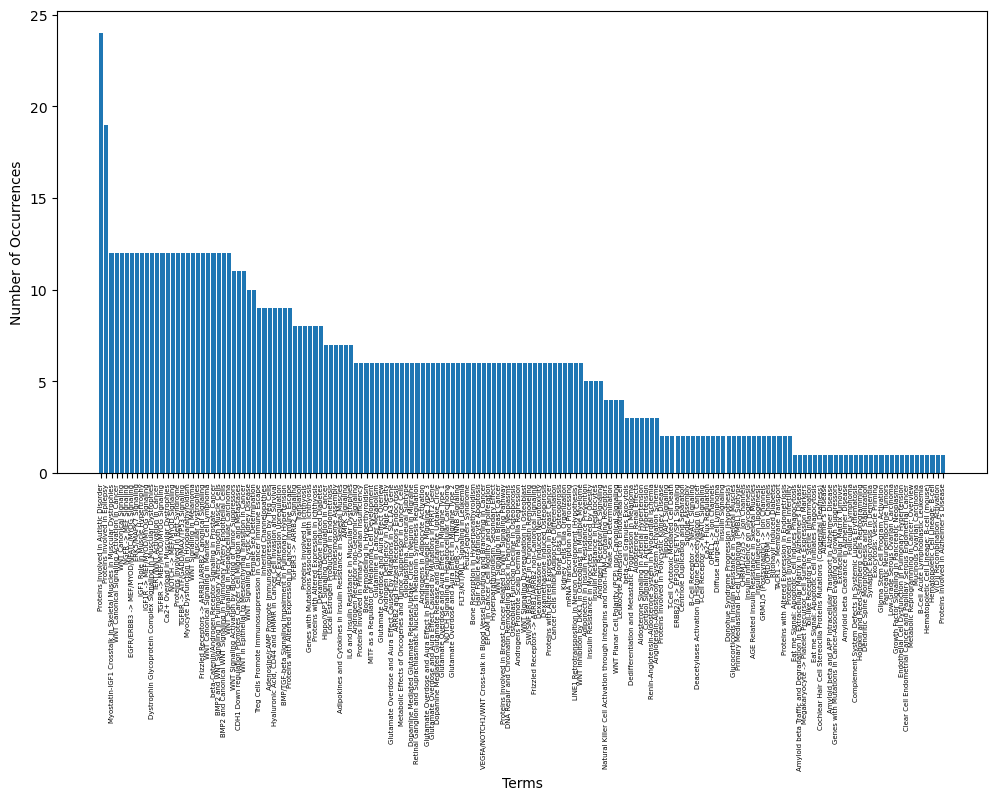

In [33]:
# Count the occurrences of each term across all cell types
term_counts = {}
for sources in significant_terms.values():
    for terms in sources.values():
        for term, _ in terms:
            if term not in term_counts:
                term_counts[term] = 0
            term_counts[term] += 1

# Create a DataFrame with the term counts and plot the distribution
term_counts_df = pd.DataFrame(list(term_counts.items()), columns=['Term', 'Count'])
term_counts_df = term_counts_df.sort_values(by='Count', ascending=False)


fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(term_counts_df['Term'], term_counts_df['Count'])
ax.set_ylabel("Number of Occurrences")
ax.set_xlabel("Terms")
plt.xticks(rotation=90)
ax.tick_params(axis='x', labelsize=5)  # Update this line with the desired fontsize
plt.show()


In [34]:
# List of terms Tto subset for their relevance in ASD. 
selected_terms = [
    'Proteins Involved in Epilepsy',
    'CHRM1/2/3/5 -> Ion Channels',
    'Proteins Involved in Rett Syndrome',
    'Dopamine Mediated Glutamate Release and Glutamate Uptake Circle',
    'Proteins Involved in Autistic Disorder',
    'Inherited Channelopathies',
]

# Filter the significant_terms dictionary to only include the selected terms
filtered_terms = {}
for celltype, sources in significant_terms.items():
    filtered_terms[celltype] = {}
    for source, terms in sources.items():
        filtered_terms[celltype][source] = [term for term in terms if term[0] in selected_terms]

print(filtered_terms)

{'Cajal Retzius cells': {'Arid2': [], 'Bcl11a': [['CHRM1/2/3/5 -> Ion Channels', 0.007986100019702], ['Inherited Channelopathies', 0.0082682234949026]], 'Ctcf': [], 'Cux1': [], 'Deaf1': [], 'Mef2c': [['Proteins Involved in Rett Syndrome', 0.0266010736954442], ['Proteins Involved in Epilepsy', 0.0266010736954442], ['Proteins Involved in Autistic Disorder', 0.0266010736954442]], 'Tcf4': [['Dopamine Mediated Glutamate Release and Glutamate Uptake Circle', 0.0318602081505673]]}, 'CThPN': {'Ctcf': [], 'Cux1': [], 'Deaf1': [], 'Foxp2': [['Proteins Involved in Autistic Disorder', 0.0047916600118212]], 'Mef2c': [['Proteins Involved in Rett Syndrome', 0.0289086135718364], ['Proteins Involved in Epilepsy', 0.0289086135718364], ['Proteins Involved in Autistic Disorder', 0.0289086135718364]], 'Meis2': [], 'Satb1': []}, 'DL CPN': {'Ctcf': [['Proteins Involved in Epilepsy', 0.0162441262213498], ['Inherited Channelopathies', 0.0339085990995554]], 'Cux1': [], 'Deaf1': [], 'Foxp2': [['Proteins Involved

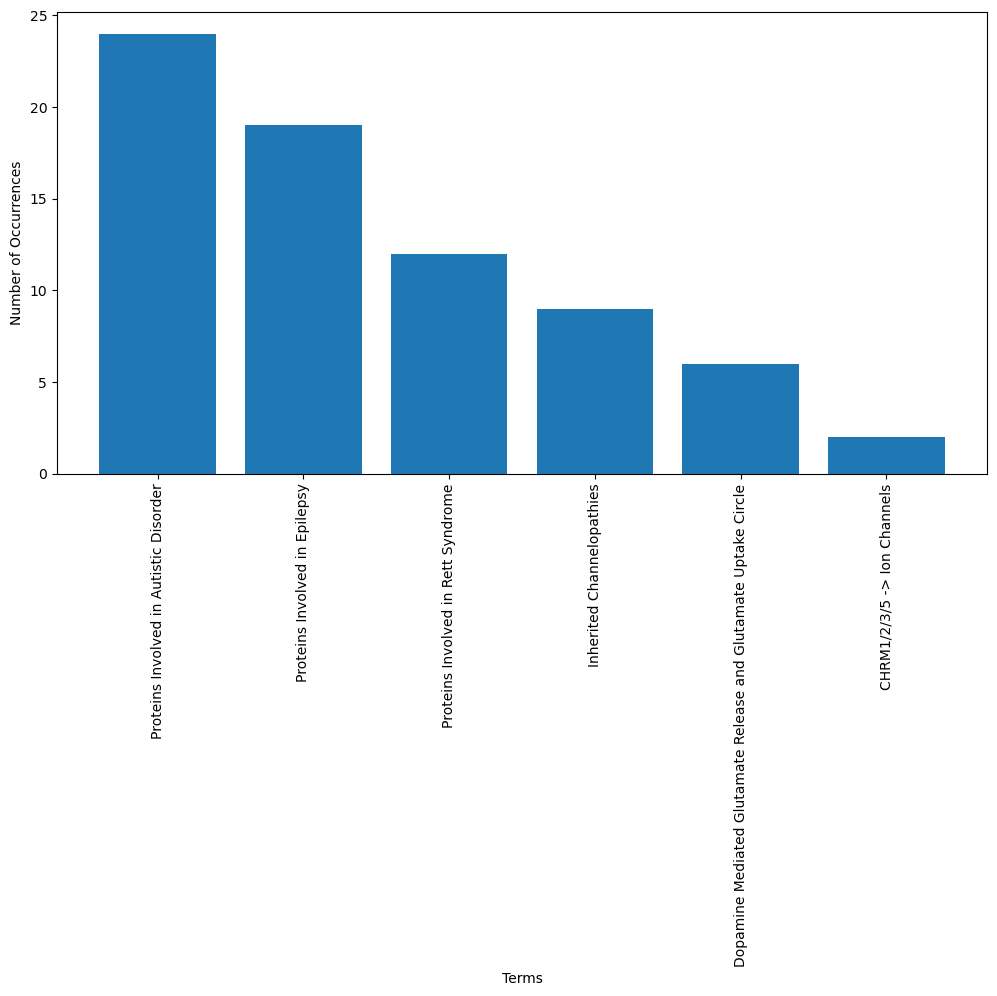

In [35]:
# Count the occurrences of each term across all cell types
term_counts = {}
for sources in filtered_terms.values():
    for terms in sources.values():
        for term, _ in terms:
            if term not in term_counts:
                term_counts[term] = 0
            term_counts[term] += 1

# Create a DataFrame with the term counts and plot the distribution
term_counts_df = pd.DataFrame(list(term_counts.items()), columns=['Term', 'Count'])
term_counts_df = term_counts_df.sort_values(by='Count', ascending=False)


fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(term_counts_df['Term'], term_counts_df['Count'])
ax.set_ylabel("Number of Occurrences")
ax.set_xlabel("Terms")
plt.xticks(rotation=90)
ax.tick_params(axis='x', labelsize=10) 
plt.show()


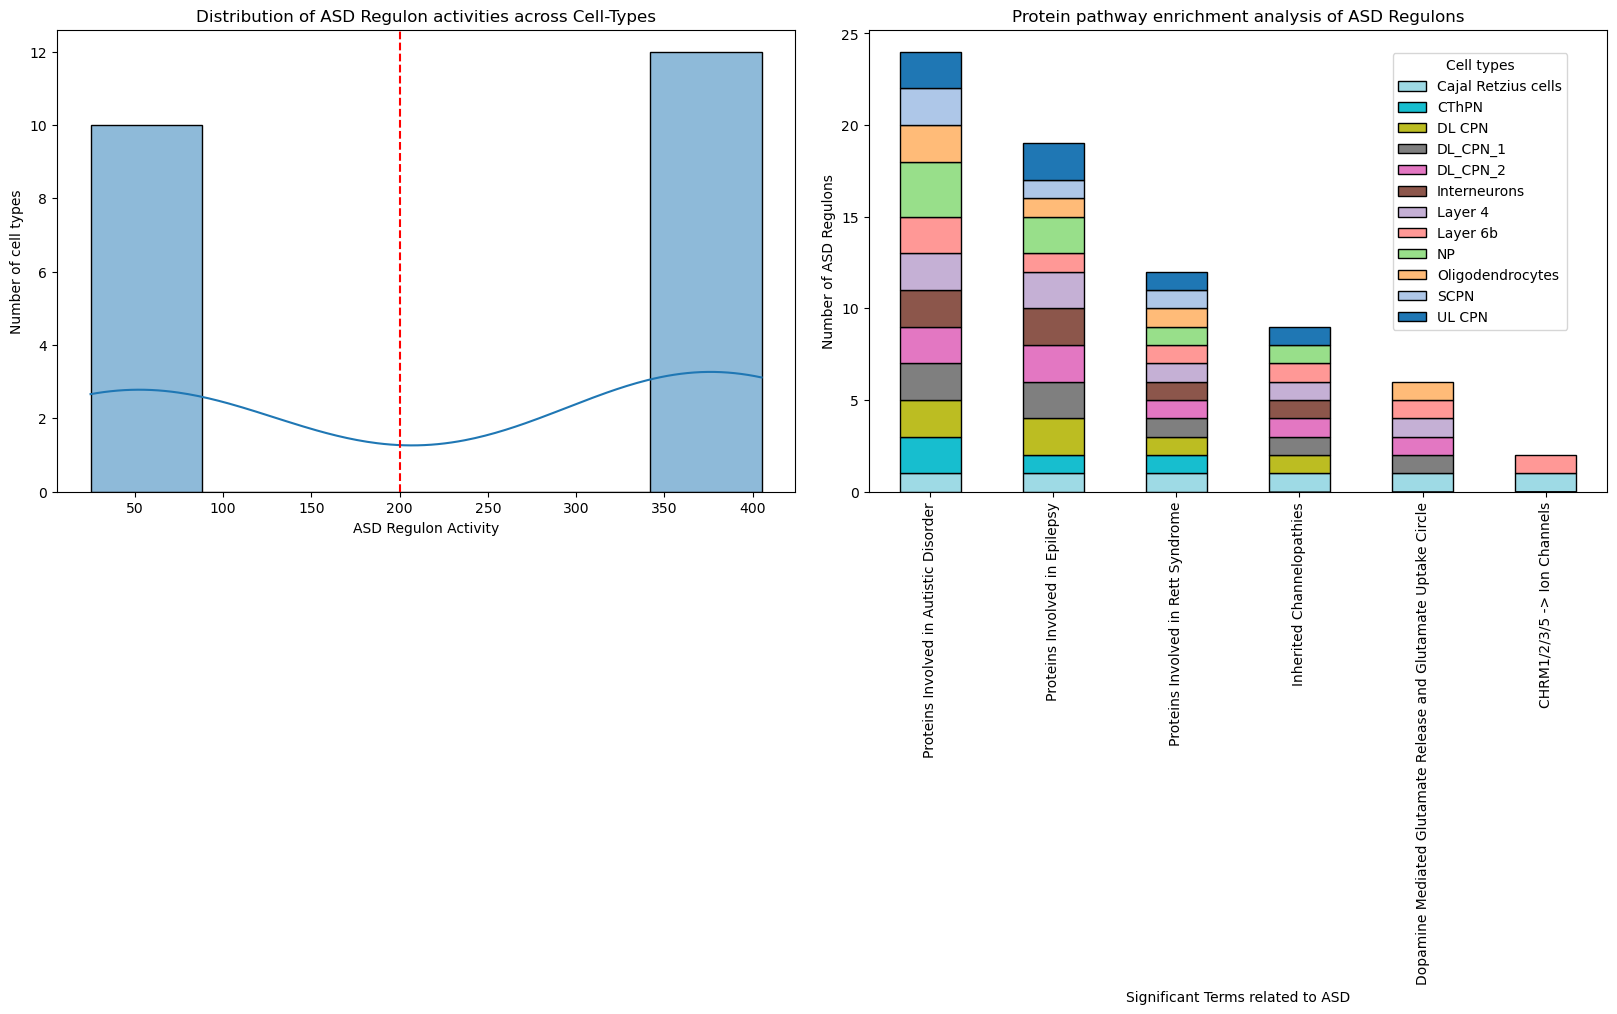

In [58]:
# Set up a 1x2 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# First plot: distribution of ASD_GRN activities
sns.histplot(ASD_GRN_df['ASD_GRN_activity'], kde=True, ax=axs[0])
axs[0].set_title("Distribution of ASD Regulon activities across Cell-Types")
axs[0].axvline(x=200, color='r', linestyle='--')
axs[0].set_xlabel("ASD Regulon Activity")  # Add the x-axis label
axs[0].set_ylabel("Number of cell types")  # Add the y-axis label

# Second plot: stacked bar chart
stacked_data.plot(kind='bar', stacked=True, ax=axs[1], colormap='tab20_r', edgecolor='black')
axs[1].set_ylabel("Number of ASD Regulons")
axs[1].set_xlabel("Significant Terms related to ASD")
axs[1].set_xticklabels(stacked_data.index, rotation=90)
axs[1].set_title("Protein pathway enrichment analysis of ASD Regulons")
legend = axs[1].legend(loc='center left', bbox_to_anchor=(0.7, 0.65), title='Cell types')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.1)

plt.show()


In [ ]:
# Create the above stacked bar-plot where the x-axis contains the enriched biological terms (protein processes) and the y-axis represents the ammount of regulons enriched for this process.
stacked_data = pd.DataFrame(0, index=selected_terms, columns=filtered_terms.keys())

for celltype, sources in filtered_terms.items():
    for source, terms in sources.items():
        for term, p_value in terms:
            stacked_data.loc[term, celltype] += 1
# Sort the stacked_data DataFrame by the sum of its rows (from highest to lowest)
stacked_data['sum'] = stacked_data.sum(axis=1)
stacked_data.sort_values(by='sum', ascending=False, inplace=True)
stacked_data.drop('sum', axis=1, inplace=True)


fig, ax = plt.subplots(figsize=(12, 6))
stacked_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20_r', edgecolor='black')
ax.set_ylabel("Number of ASD regulons", size =18)
ax.set_xlabel("Selected significant Terms", size =18)
plt.xticks(rotation=90)

# Add a title to the plot
ax.set_title("Pathway enrichment analysis of ASD\n regulons in the enriched cell types",size=24)

# Move the legend outside the plot frame and add a title
ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.62), title='Cell types')

# Save the plot with the specified DPI
#output_path = r"/wholedataGSEA.pdf"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

## END